In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
from numba import jit, njit

plt.style.use(['science', 'grid', 'notebook'])

# Ejercicio 2

Considere una red neuronal de Kohonen con dos neuronas de entrada. Utilice 10 neuronas de salida, dispuestas sobre una línea. Alimente a las neuronas de entrada con una distribución.

$$ P(\overline{\xi}) = P(r, \theta) =  

\begin{cases}
    cte \quad \text{si } r \in [0.9, 1.1], \theta \in [0, \pi] \\
    0 \quad \text{sino}
\end{cases}
$$

donde $r$ y $\theta$ son las coordenadas polares del vector $\overline{\xi}$. Es decir $r = \sqrt{\xi_1^2 + \xi_2^2}$ y $\theta = \arctan(\xi_2/\xi_1)$. Utilizar la función "vecindad" gaussiana:

$$\Lambda(i, i^*) \propto \exp \left(-\frac{(i-i^*)^2}{2\sigma^2}\right)$$

Verifique la posiciónn asintótica de los pesos sinápticos para distintos tiempos de entrenamiento y valores de $\sigma$

In [2]:
@njit
def generate_data(r_range, num_points, iter_max=1000):
    data = np.zeros((num_points, 2))
    for i in range(num_points):
        flag = False
        for j in range(iter_max):
            # print(j)
            x = np.random.uniform(-1.1, 1.1)
            y = np.random.uniform(0, 1.1)
            
            r = np.sqrt(x**2 + y**2)
            # theta = np.arctan2(y, x)

            if r_range[0] < r < r_range[1]:
                data[i] = np.array([x, y])
                flag = True
                break   # break this for
        if not flag:
            raise StopIteration("Iteration limit reached without generating the desired number of points")
        
    return data


Generated 10000 data points


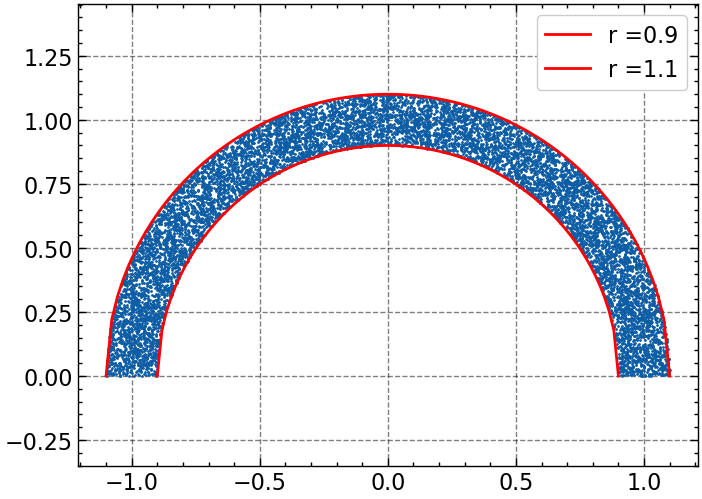

In [3]:
# Example usage
r_range = (0.9, 1.1)    # range of r
theta_range = (0, np.pi)    # range of theta
num_points = 10000

# circle
circle = lambda r, x: np.sqrt(r**2 - x**2)

try:
    data = generate_data(r_range, num_points)
    print("Generated {} data points".format(data.shape[0]))

    plt.scatter(data[:, 0], data[:, 1], s=1)
    domain_1 = np.linspace(-r_range[0], r_range[0],100)
    domain_2 = np.linspace(-r_range[1], r_range[1], 100)

    plt.plot(domain_1, circle(r_range[0], domain_1), color='red', label=f'r ={r_range[0]}')
    plt.plot(domain_2, circle(r_range[1], domain_2), color='red', label=f'r ={r_range[1]}')

    plt.legend()
    plt.axis('equal')
except StopIteration as e:
    print(e)

In [45]:
@njit
def neighbor_function(i, i_max, sigma):
    return np.exp(-((i-i_max)**2)/(2*sigma**2))

@njit
def begin(NI, NO):
    y_seed = np.random.uniform(0, 1.1, NO)
    x_seed = np.random.uniform(-1.1, 1.1, NO)
    return np.stack((x_seed, y_seed), axis=0)
    # return np.random.uniform(-0.5, 0.5, (NI, NO))
# @njit
# def train(X, W, lr, sigma):
#     for xi in X:
#         xi = np.ascontiguousarray(xi)
#         # Find the winner neuron
#         winner = np.argmin(np.sum((xi.reshape(-1,1) - W)**2, axis=0))

#         # Update the weights
#         for i in range(W.shape[1]):
#             W[:, i] += lr * neighbor_function(i, winner, sigma) * (xi - W[:, i])
        
#     return W


#     return W

@njit
def train(X, W, lr, sigma, W_history):
    for t, xi in enumerate(X):
        # Asegurarse de que xi sea contiguo
        xi = np.ascontiguousarray(xi)
        
        # Encontrar la neurona ganadora
        winner = np.argmin(np.sum((xi.reshape(-1, 1) - W)**2, axis=0))

        # Actualizar los pesos
        for i in range(W.shape[1]):
            W[:, i] += lr * neighbor_function(i, winner, sigma) * (xi - W[:, i])
        
        # Guardar los pesos en el historial
        W_history[t] = W.copy()
        
    return W

In [75]:
NI = 2
NO = 10
n_data = 10000001

lr = 0.1
sigmas = np.array([0.4, 0.8, 1.0, 2.0])

np.random.seed(8)
W_begin = begin(NI, NO)
data = generate_data(r_range, n_data)
print(data.shape)

(10000001, 2)


Grafico la seed

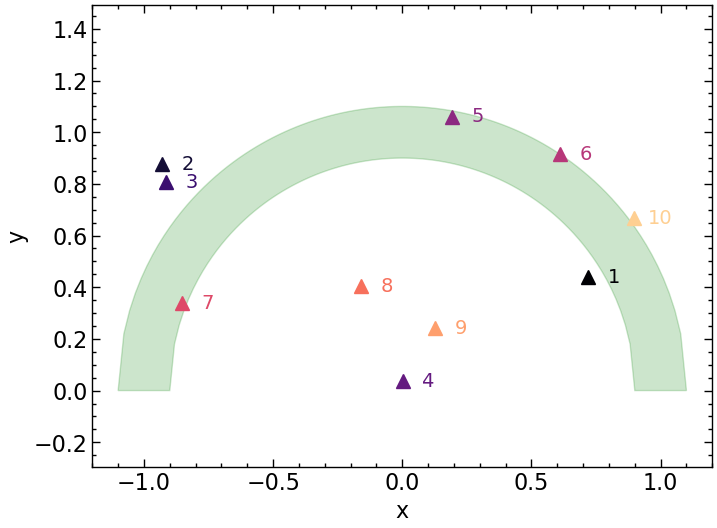

In [99]:
# Ejemplo de datos
r_range = (0.9, 1.1)
domain_1 = np.linspace(-r_range[0], r_range[0], 100)
domain_2 = np.linspace(-r_range[1], r_range[1], 100)
y_upper = circle(r_range[1], domain_2)
y_lower = circle(r_range[0], domain_1)

fig, ax = plt.subplots(figsize=(8, 6))
cm = plt.get_cmap('magma')
epsilon= 0.1

# Graficar los semicírculos
ax.fill(np.concatenate((domain_2, domain_1[::-1])), np.concatenate((y_upper, y_lower[::-1])), color='green', alpha=0.2)

for i in range(W_begin.shape[1]):
    ax.plot(W_begin[0, i], W_begin[1, i], '^', color=cm(i/W_begin.shape[1]), ms=10, label=f'{i}')
    ax.text(W_begin[0, i]+epsilon, W_begin[1, i], f'{i+1}', fontsize=14, color=cm(i/W_begin.shape[1]), ha='center', va='center')
# Etiquetas y título

ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.legend(title='Neurona', fon÷tsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', ncols=2)
ax.axis('equal')
ax.grid()
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 1.2)


# Mostrar el gráfico
plt.savefig('../doc/figures/cond_inicial.pdf', dpi=500)

In [77]:
# Inicializar el historial de pesos
W_history = np.empty((sigmas.shape[0], data.shape[0], NI, NO))
W = np.empty((sigmas.shape[0], NI, NO))

for i in tqdm.tqdm(range(sigmas.shape[0]), desc="Training"):
    W[i] = train(data, np.copy(W_begin), lr, sigmas[i], W_history[i])

Training: 100%|██████████| 4/4 [01:05<00:00, 16.49s/it]


Grafico los resultados

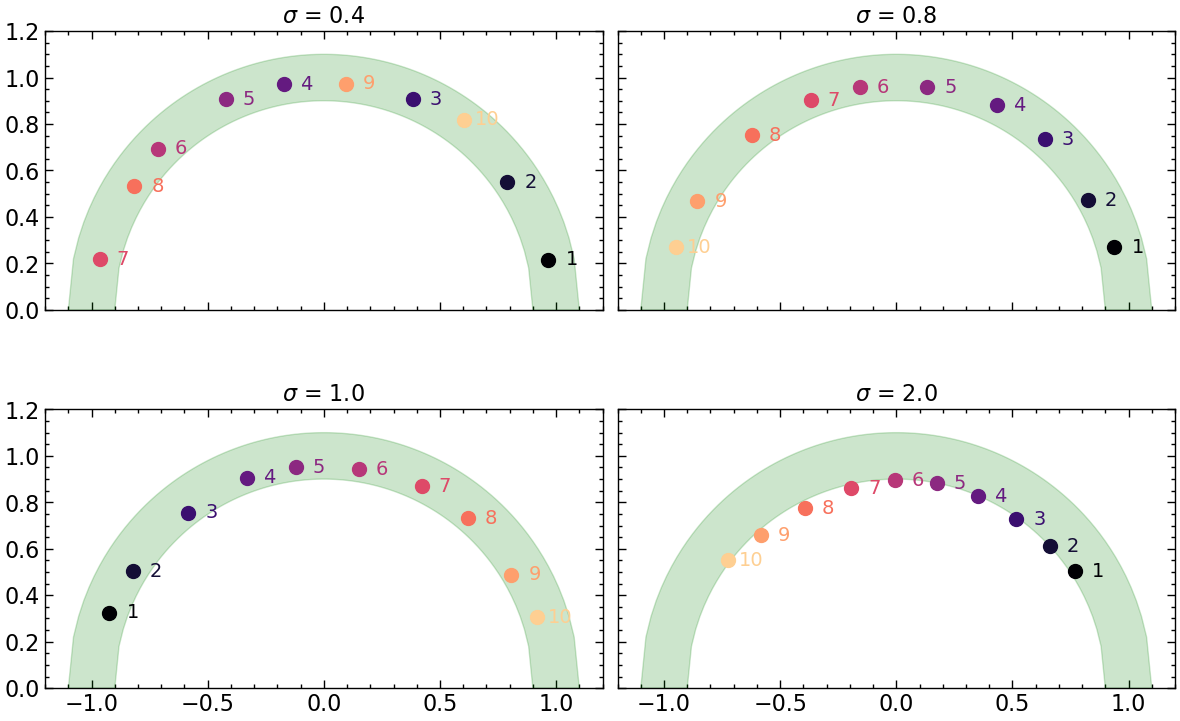

In [78]:
# Ejemplo de datos
r_range = (0.9, 1.1)
domain_1 = np.linspace(-r_range[0], r_range[0], 100)
domain_2 = np.linspace(-r_range[1], r_range[1], 100)
y_upper = circle(r_range[1], domain_2)
y_lower = circle(r_range[0], domain_1)

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
cm = plt.get_cmap('magma')

epsilon = 0.1
x_limits = (-1.2, 1.2)
y_limits = (0, 1.2)

for i in range(W.shape[0]):
    # plot semicircle
    ax[i//2, i%2].fill(np.concatenate((domain_2, domain_1[::-1])), np.concatenate((y_upper, y_lower[::-1])), color='green', alpha=0.2)
    for j in range(W.shape[2]):
        ax[i//2, i%2].plot(W[i, 0, j], W[i, 1, j], 'o', color=cm(j/W.shape[2]), ms=10, label=f'{j}')
        # ax[i//2, i%2].plot(W_begin[0, j], W_begin[1, j], '^', color=cm(j/W_begin.shape[1]), ms=10, label=f'{j}')
        ax[i//2, i%2].set_title(rf'$\sigma$ = {sigmas[i]}')
        ax[i//2, i%2].text(W[i, 0, j]+epsilon, W[i, 1, j], f'{j+1}', fontsize=14, color=cm(j/W.shape[2]), ha='center', va='center')
        
    ax[i//2, i%2].set_aspect('equal', adjustable='box')  # Establecer la misma escala en los ejes x e y
    ax[i//2, i%2].set_xlim(x_limits)
    ax[i//2, i%2].set_ylim(y_limits)
    ax[i//2, i%2].grid()
plt.tight_layout()

In [79]:
W_history.shape

(4, 10000001, 2, 10)

[       0      100   100000 10000000]


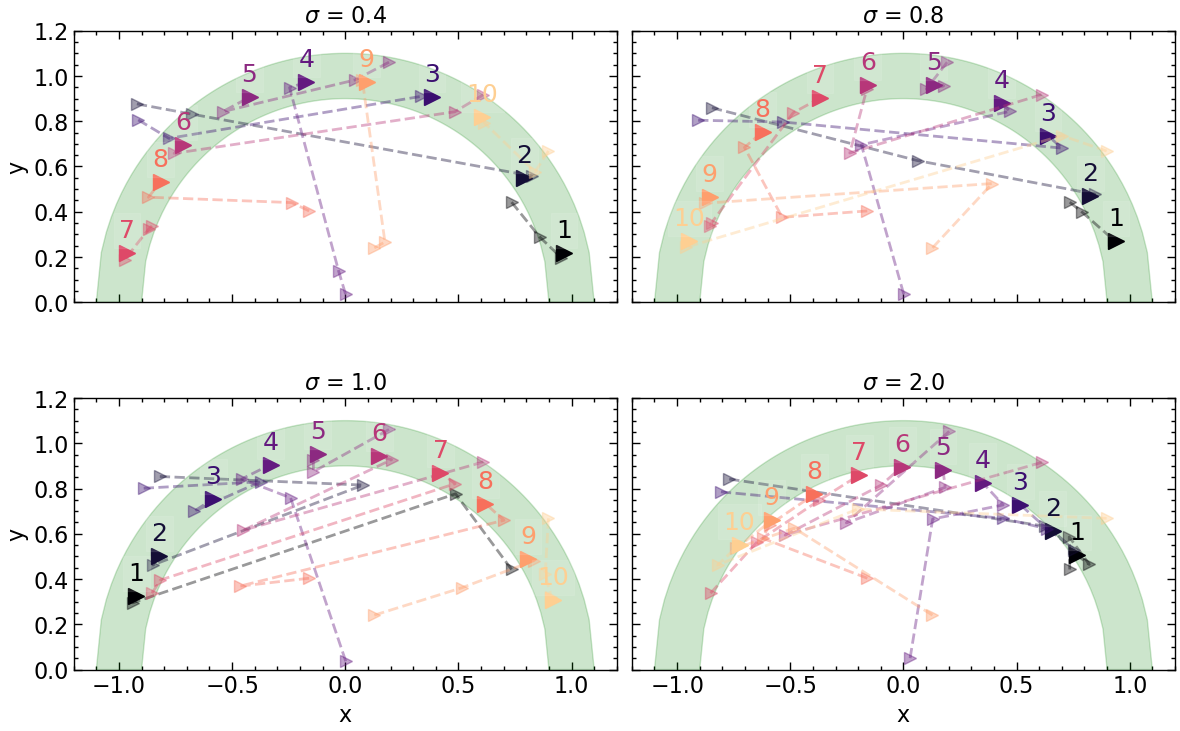

In [98]:
# index = np.arange(0, data.shape[0], data.shape[0]//n_epcohs, dtype=np.int64)
index = np.array([0, 1e2, 1e5, data.shape[0]-1], dtype=np.int64)

print(index)

# # Ejemplo de datos
r_range = (0.9, 1.1)
domain_1 = np.linspace(-r_range[0], r_range[0], 100)
domain_2 = np.linspace(-r_range[1], r_range[1], 100)
y_upper = circle(r_range[1], domain_2)
y_lower = circle(r_range[0], domain_1)

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
cm = plt.get_cmap('magma')

epsilon = 0.1
x_limits = (-1.2, 1.2)
y_limits = (0, 1.2)

for i in range(W_history.shape[0]):
    # plot semicircle
    ax[i//2, i%2].fill(np.concatenate((domain_2, domain_1[::-1])), np.concatenate((y_upper, y_lower[::-1])), color='green', alpha=0.2)

    for j in range(W_history.shape[3]):
        # for k in index:
        ax[i//2, i%2].plot(W_history[i, index, 0, j], W_history[i, index, 1, j], '>--', color=cm(j/W_history.shape[3]), ms=8, label=f'{j}', alpha=0.4)
        
        ax[i//2, i%2].plot(W[i, 0, j], W[i, 1, j], '>', color=cm(j/W.shape[2]), ms=12, label=f'{j}')
        # for k in index:
        ax[i//2, i%2].text(W_history[i, -1, 0, j], W_history[i, -1, 1, j]+epsilon, f'{j+1}', fontsize=18, color=cm(j/W_history.shape[3]), ha='center', va='center', bbox=dict(facecolor='white', alpha=0.1, edgecolor='white'))
        ax[i//2, i%2].set_title(rf'$\sigma$ = {sigmas[i]}')
        
    ax[i//2, i%2].set_aspect('equal', adjustable='box')  # Establecer la misma escala en los ejes x e y
    ax[i//2, i%2].set_xlim(x_limits)
    ax[i//2, i%2].set_ylim(y_limits)
    ax[i//2, i%2].grid()

ax[0,0].set_ylabel('y')
ax[1,0].set_ylabel('y')
ax[1,1].set_xlabel('x')
ax[1,0].set_xlabel('x')
plt.tight_layout()
plt.savefig('../doc/figures/ej_2_trainings.pdf', dpi=500)
